In [1]:
import pandas as pd
import numpy as np
import os
import enum
import time
import matplotlib.pyplot as plt
import utils
import json
import seaborn as sns

from tqdm.auto import tqdm, trange

import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

from sklearn.model_selection import LeaveOneOut, train_test_split,cross_validate
from sklearn.metrics import precision_recall_curve

from datetime import datetime

In [11]:
dfs = {}

for algorithm in ["logreg", "svm", "knn", "mlp", "gauss"]:
    dfs[algorithm] = utils.printTableUniMulti(
        f"../study/stats/results-{algorithm}-loo-filter-Uni-Multi.json",
        score="acc",
        skip_uni=["fechner_corr", "gini_index", "information_gain", "pearson_corr", "su_measure"],
        skip_multi=["CMIM", "IWFS", "JMI", "MIM"],
        add_uni={
            "Mannwhiten": f"../study/stats/results-{algorithm}-loo-filter-Man-Multi.json",
            "Mannwhiten+Kruscal": f"../study/stats/results-{algorithm}-loo-filter-ManKru-Multi.json"
        }
    )
    print()

                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.7143	0.6429	0.7662	0.8117	0.6429	0.7857	
        kendall_corr	0.7403	0.5000	0.7143	0.5000	0.6429	0.5000	
     reliefF_measure	0.5000	0.7662	0.5000	0.6429	0.5000	0.5000	
       spearman_corr	0.5000	0.5000	0.6688	0.5714	0.5000	0.5714	
          Mannwhiten	0.8117	0.7403	0.6429	0.7143	0.8117	0.6429	
  Mannwhiten+Kruscal	0.6429	0.7403	0.6429	0.7403	0.7403	0.7662	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.5974	0.8117	0.6429	0.7403	0.5714	0.8117	
        kendall_corr	0.6429	0.5714	0.5714	0.5714	0.5714	0.5000	
     reliefF_measure	0.5000	0.6429	0.5000	0.6429	0.5000	0.5714	
       spearman_corr	0.5000	0.5000	0.5000	0.5714	0.5000	0.5714	
          Mannwhiten	0.6429	0.5974	0.5000	0.5714	0.5714	0.6688	
  Mannwhiten+Kruscal	0.5000	0.5000	0.5000	0.5000	0.5000	0.5000	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.8117	0.5000	0.5974	0.8636	0.6429	0.7143	


In [1]:
fig = sns.heatmap(dfs["logreg"], annot=True, fmt=".3f", vmin=0, vmax=1, cmap="coolwarm")
plt.title("Logistic Regression AUC-ROC score")
plt.savefig("../imgs/prediction_scores/auc-logreg-uni+multi.png",dpi=300, bbox_inches="tight")

NameError: name 'sns' is not defined

In [3]:
dfs = {}

for algorithm in ["logreg", "svm", "knn", "mlp", "gauss"]:
    dfs[algorithm] = utils.printTableUniMulti(
        f"../study/stats/results-{algorithm}-loo-filter-Uni-Multi-sfs.json",
        score="auc",
        add_uni={
            "Mannwhiten": f"../study/stats/results-{algorithm}-loo-filter-Man-Multi-sfs.json",
            "Mannwhiten+Kruscal": f"../study/stats/results-{algorithm}-loo-filter-ManKru-Multi-sfs.json"
        }
    )
    print()

                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.6234	0.6234	0.5195	0.5195	0.6364	0.6364	
        kendall_corr	0.6299	0.6299	0.6299	0.6299	0.6299	0.6299	
     reliefF_measure	0.3377	0.4805	0.2468	0.6104	0.4545	0.7013	
       spearman_corr	0.5974	0.3247	0.4935	0.3506	0.3247	0.4675	
          Mannwhiten	0.6623	0.7662	0.6883	0.8182	0.8571	0.7403	
  Mannwhiten+Kruscal	0.6104	0.5519	0.9091	0.4610	0.5974	0.8182	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.5974	0.5714	0.5714	0.5844	0.6883	0.6104	
        kendall_corr	0.4286	0.4286	0.4286	0.4286	0.4286	0.4286	
     reliefF_measure	0.3896	0.4675	0.2078	0.7273	0.6364	0.5455	
       spearman_corr	0.6623	0.3506	0.6104	0.3377	0.3506	0.2208	
          Mannwhiten	0.6104	0.6364	0.4156	0.7143	0.8442	0.6753	
  Mannwhiten+Kruscal	0.7403	0.5974	0.8052	0.4805	0.7403	0.6623	
                    	CFR 	CIFE 	DCSF 	ICAP 	MRI 	MRMR 	
     f_ratio_measure	0.4740	0.5390	0.7922	0.6429	0.6688	0.6883	


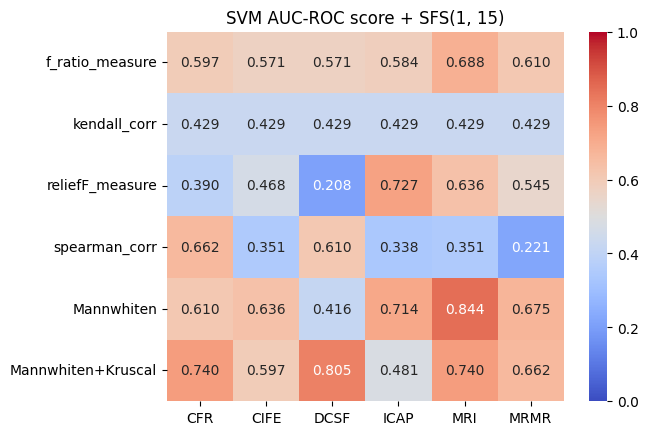

In [4]:
sns.heatmap(dfs["svm"], annot=True, fmt=".3f", vmin=0, vmax=1, cmap="coolwarm")
plt.title("SVM AUC-ROC score + SFS(1, 15)")
plt.savefig("../imgs/prediction_scores/auc-svm-uni+multi+sfs.png",dpi=300, bbox_inches="tight")

In [52]:
import utils

df = utils.getReducedDS()
X, y, y3 = utils.splitFeatureLabels(df)

## Logistic Regression

In [53]:
from sklearn.model_selection import cross_validate, LeaveOneOut
from sklearn.preprocessing import RobustScaler
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.pipeline import Pipeline
from ITMO_FS.filters import multivariate
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer

cv_log = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", RobustScaler().set_output(transform="pandas")),
            ("t-test", utils.MannwhitenFilter(0.05)),
            ("ANOVA", utils.KruskalFilter(y3, 0.05)),
            ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
            ("multivariate", multivariate.MultivariateFilter("DCSF", 20)),
            ("sfs", SFS(
                LogisticRegression(random_state=7, class_weight="balanced"),
                k_features=(1,15),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", LogisticRegressionCV(
            random_state=7,
            class_weight="balanced",
            scoring="neg_log_loss",
            cv=3,
            n_jobs=1
        ))
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_proba=True),
    cv=LeaveOneOut(),
    n_jobs=8,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time= 4.1min
[CV] END .................................................... total time= 4.2min
[CV] END .................................................... total time= 4.2min
[CV] END .................................................... total time= 4.3min
[CV] END .................................................... total time= 4.3min
[CV] END .................................................... total time= 4.4min
[CV] END .................................................... total time= 4.7min
[CV] END .................................................... total time= 4.8min
[CV] END .................................................... total time= 4.1min
[CV] END .................................................... total time= 4.5min
[CV] END .................................................... total time= 4.3min
[CV] END .................................................... total time= 4.5min
[CV] END ...................

[Parallel(n_jobs=8)]: Done  13 out of  18 | elapsed:  8.9min remaining:  3.4min


[CV] END .................................................... total time= 4.7min
[CV] END .................................................... total time= 4.7min
[CV] END .................................................... total time= 4.5min
[CV] END .................................................... total time= 3.0min
[CV] END .................................................... total time= 3.8min


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed: 12.4min finished


In [8]:
most_selected = {}
for estimator in cv_log["estimator"]:
    for feature in estimator["selection"]["sfs"].k_feature_names_:
        if feature not in most_selected:
            most_selected[feature] = 0
        else:
            most_selected[feature] += 1
    
    # print(estimator["selection"]["sfs"].k_feature_names_)

most_selected

{'Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized': 9,
 'Left-Accumbens-area_AD_lbp-3D-k_glcm_ClusterProminence': 2,
 'Right-Thalamus_wfvf_wavelet-HLL_glszm_SizeZoneNonUniformityNormalized': 4,
 'Left-Accumbens-area_AD_lbp-3D-k_firstorder_Entropy': 1,
 'Right-Pallidum_fextra_wavelet-LLL_glszm_HighGrayLevelZoneEmphasis': 0,
 'lh.or_frac_csf_d_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized': 0,
 'Right-Thalamus_odi_wavelet-HLL_glszm_GrayLevelNonUniformityNormalized': 0,
 'lh.ar_frac_csf_d_wavelet-LLH_glszm_GrayLevelVariance': 0,
 'Right-Amygdala_frac_csf_mf_wavelet-LHL_glszm_ZoneEntropy': 0,
 'rh.uf_frac_csf_mf_wavelet-LLL_glszm_HighGrayLevelZoneEmphasis': 0}

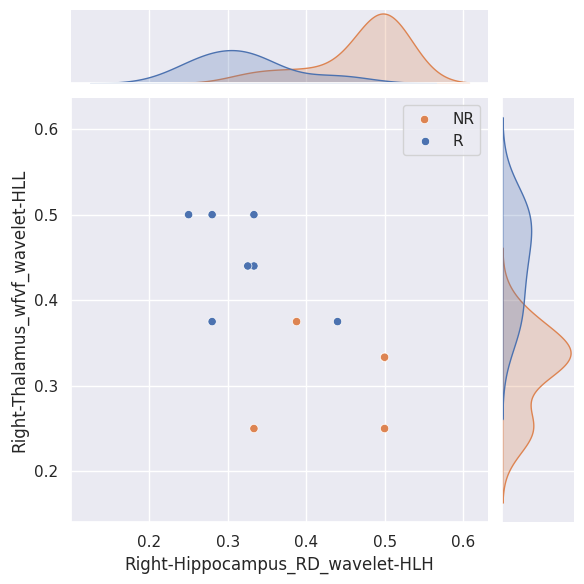

In [49]:
sns.jointplot(data=X, x='Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', y='Right-Thalamus_wfvf_wavelet-HLL_glszm_SizeZoneNonUniformityNormalized', hue=y, palette="deep")
plt.xlabel("Right-Hippocampus_RD_wavelet-HLH")
plt.ylabel("Right-Thalamus_wfvf_wavelet-HLL")
plt.legend(["NR", "R"])
plt.savefig("../imgs/confusionMatrices/bestfeatures.png",dpi=300, bbox_inches="tight")

AUC:		Test: 0.909
f1:		Test: 0.957
Accuracy:	Test: 0.857
Accuracy not adjusted: 0.929 0.944
Brier:		Test: 0.109
LogLoss:	Test 0.470


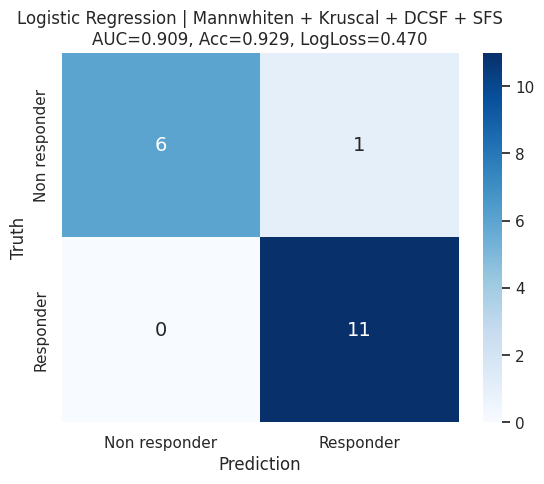

In [18]:
scores = utils.printScores(y, cv_log["test_score"], confusion=True)
plt.title("Logistic Regression | Mannwhiten + Kruscal + DCSF + SFS\nAUC=0.909, Acc=0.929, LogLoss=0.470")
plt.savefig("../imgs/confusionMatrices/logreg.png",dpi=300, bbox_inches="tight")

In [28]:
def printScoresPredicions(scores, y, y3):
    return pd.concat([pd.Series(scores["prob_decision"], index=y.index),pd.Series(scores["prob_decision"]>=scores["threshold"], index=y.index), y, y3], axis=1)

In [ ]:
printScoresPredicions(scores, y, y3)

,0,1,resp,respPart
ID,,,,
VNSLC_01,0.840411,True,1,2
VNSLC_02,1.000000,True,1,2
VNSLC_03,0.662642,True,1,2
VNSLC_04,0.840411,True,1,2
VNSLC_06,0.277690,False,0,0
VNSLC_07,0.603145,True,1,2
VNSLC_09,0.840411,True,1,2
VNSLC_10,1.000000,True,1,1
VNSLC_11,0.446106,True,1,2


## Gaussian 1

In [ ]:
from sklearn.naive_bayes import GaussianNB

cv_gauss1 = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", RobustScaler().set_output(transform="pandas")),
            ("t-test", utils.MannwhitenFilter(0.05)),
            ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
            ("multivariate", multivariate.MultivariateFilter("MRI", 20)),
            ("sfs", SFS(
                GaussianNB(),
                k_features=(1,15),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", GaussianNB())
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_proba=True),
    cv=LeaveOneOut(),
    n_jobs=8,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

In [70]:
most_selected = {}
for estimator in cv_gauss1["estimator"]:
    for feature in estimator["selection"]["sfs"].k_feature_names_:
        if feature not in most_selected:
            most_selected[feature] = 1
        else:
            most_selected[feature] += 1
    
    # print(estimator["selection"]["sfs"].k_feature_names_)

most_selected

{'Left-Pallidum_frac_csf_d_wavelet-LLL_glszm_ZoneVariance': 1,
 'Right-Caudate_RD_wavelet-HHL_glszm_GrayLevelVariance': 3,
 'rh.ilf_fvf_tot_lbp-3D-m1_firstorder_Median': 1,
 'lh.cbv_frac_csf_d_wavelet-HLH_glszm_SizeZoneNonUniformity': 1,
 'rh.ar_wAD_wavelet-LHH_glszm_SizeZoneNonUniformity': 1,
 'lh.ar_wAD_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized': 2,
 'Right-Thalamus_wFA_wavelet-LLH_glszm_GrayLevelNonUniformityNormalized': 3,
 'Left-Caudate_fextra_lbp-3D-m1_firstorder_Median': 1,
 'lh.ar_wMD_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized': 1,
 'lh.or_frac_csf_d_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized': 3,
 'Left-Accumbens-area_AD_lbp-3D-k_glcm_ClusterProminence': 3,
 'Left-Caudate_frac_csf_mf_lbp-3D-k_glszm_SizeZoneNonUniformityNormalized': 1,
 'lh.ar_frac_csf_d_wavelet-LLH_glszm_GrayLevelNonUniformityNormalized': 2,
 'lh.cbd_wMD_lbp-3D-m1_firstorder_Median': 2,
 'lh.cbv_fiso_wavelet-HHH_glszm_GrayLevelNonUniformity': 1,
 'rh.atr_frac_csf_mf_wavelet-HLL_glszm_L

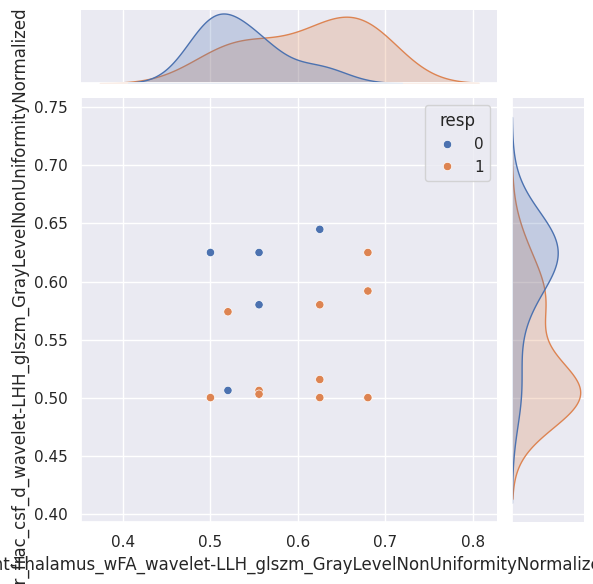

In [71]:
sns.jointplot(data=X, x='Right-Thalamus_wFA_wavelet-LLH_glszm_GrayLevelNonUniformityNormalized', y='lh.or_frac_csf_d_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized', hue=y, palette="deep")

AUC:		Test: 0.961
f1:		Test: 0.917
Accuracy:	Test: 0.714
Accuracy not adjusted: 0.857 0.889
Brier:		Test: 0.112
LogLoss:	Test 0.342


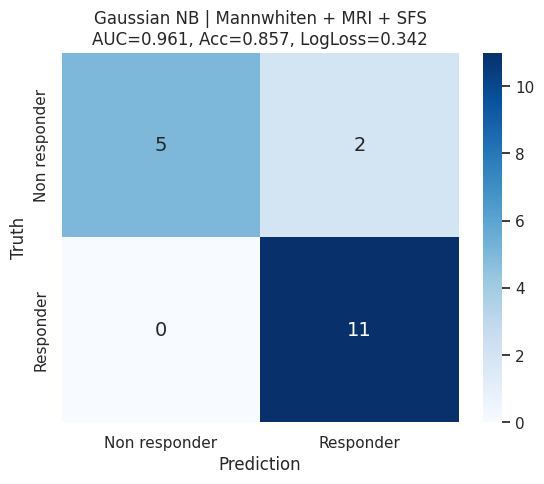

In [20]:
scores = utils.printScores(y, cv_gauss1["test_score"], confusion=True)
plt.title("Gaussian NB | Mannwhiten + MRI + SFS\nAUC=0.961, Acc=0.857, LogLoss=0.342")
plt.savefig("../imgs/confusionMatrices/gauss_mann.png",dpi=300, bbox_inches="tight")

In [ ]:
printScoresPredicions(scores, y, y3)

,0,1,resp,respPart
ID,,,,
VNSLC_01,1.000000,True,1,2
VNSLC_02,0.080473,True,1,2
VNSLC_03,0.999864,True,1,2
VNSLC_04,1.000000,True,1,2
VNSLC_06,0.023621,False,0,0
VNSLC_07,0.487914,True,1,2
VNSLC_09,0.762465,True,1,2
VNSLC_10,0.999669,True,1,1
VNSLC_11,0.991134,True,1,2


## Gaussian 2

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.pipeline import Pipeline
from ITMO_FS.filters import multivariate
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer

cv_gauss2 = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", RobustScaler().set_output(transform="pandas")),
            ("t-test", utils.MannwhitenFilter(0.05)),
            ("ANOVA", utils.KruskalFilter(y3, 0.05)),
            ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
            ("multivariate", multivariate.MultivariateFilter("DCSF", 20)),
            ("sfs", SFS(
                GaussianNB(),
                k_features=(1,15),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", GaussianNB())
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_proba=True),
    cv=LeaveOneOut(),
    n_jobs=8,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time= 4.4min
[CV] END .................................................... total time= 4.3min
[CV] END .................................................... total time= 4.4min
[CV] END .................................................... total time= 4.5min
[CV] END .................................................... total time= 4.5min
[CV] END .................................................... total time= 4.6min
[CV] END .................................................... total time= 4.9min
[CV] END .................................................... total time= 5.0min
[CV] END .................................................... total time= 4.5min
[CV] END .................................................... total time= 4.4min
[CV] END .................................................... total time= 4.5min
[CV] END .................................................... total time= 4.2min
[CV] END ...................

[Parallel(n_jobs=8)]: Done  13 out of  18 | elapsed:  9.2min remaining:  3.6min


[CV] END .................................................... total time= 4.8min
[CV] END .................................................... total time= 4.7min
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 4.1min


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed: 13.1min finished


In [23]:
most_selected = {}
for estimator in cv_gauss2["estimator"]:
    for feature in estimator["selection"]["sfs"].k_feature_names_:
        if feature not in most_selected:
            most_selected[feature] = 0
        else:
            most_selected[feature] += 1
    
    # print(estimator["selection"]["sfs"].k_feature_names_)

most_selected

{'Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized': 8,
 'Right-Thalamus_wfvf_wavelet-HLL_glszm_SizeZoneNonUniformityNormalized': 4,
 'lh.ar_frac_csf_d_wavelet-LLH_glszm_GrayLevelVariance': 0,
 'lh.ar_frac_csf_d_wavelet-LLH_glszm_GrayLevelNonUniformityNormalized': 1,
 'lh.or_frac_csf_d_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized': 1,
 'Left-Accumbens-area_AD_lbp-3D-k_glcm_ClusterProminence': 1,
 'Right-Pallidum_fextra_wavelet-LLL_glszm_GrayLevelVariance': 1,
 'Right-Pallidum_fextra_wavelet-LLL_glszm_HighGrayLevelZoneEmphasis': 0,
 'Right-Thalamus_odi_wavelet-HLL_glszm_GrayLevelVariance': 0,
 'Left-Caudate_FA_wavelet-HHL_glszm_GrayLevelNonUniformityNormalized': 0,
 'rh.uf_frac_csf_mf_wavelet-LLL_glszm_HighGrayLevelZoneEmphasis': 0}

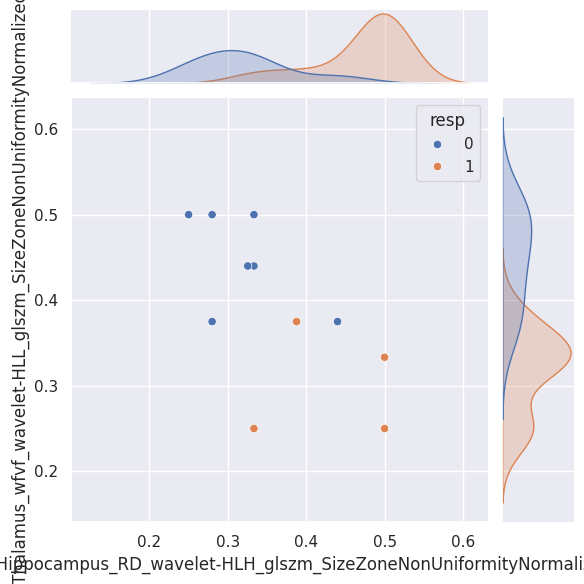

In [73]:
sns.jointplot(data=X, x='Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', y='Right-Thalamus_wfvf_wavelet-HLL_glszm_SizeZoneNonUniformityNormalized', hue=y, palette="deep")

AUC:		Test: 0.857
f1:		Test: 0.957
Accuracy:	Test: 0.857
Accuracy not adjusted: 0.929 0.944
Brier:		Test: 0.082
LogLoss:	Test 1.589


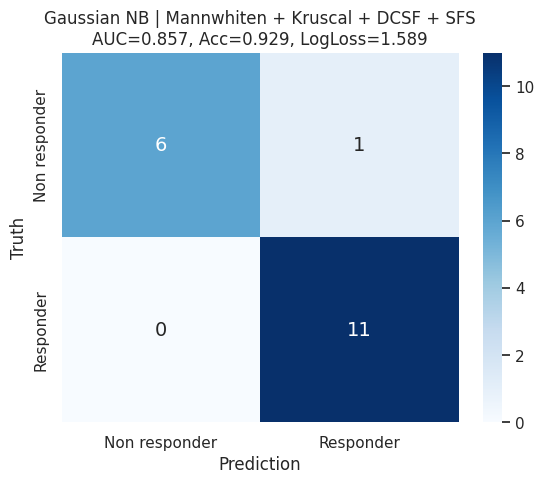

In [21]:
scores = utils.printScores(y, cv_gauss2["test_score"], confusion=True)
plt.title("Gaussian NB | Mannwhiten + Kruscal + DCSF + SFS\nAUC=0.857, Acc=0.929, LogLoss=1.589")
plt.savefig("../imgs/confusionMatrices/gauss_mann_krus.png",dpi=300, bbox_inches="tight")

In [ ]:
printScoresPredicions(scores, y, y3)

,0,1,resp,respPart
ID,,,,
VNSLC_01,0.994070,True,1,2
VNSLC_02,0.999621,True,1,2
VNSLC_03,0.986850,True,1,2
VNSLC_04,0.994070,True,1,2
VNSLC_06,0.092562,False,0,0
VNSLC_07,0.794415,True,1,2
VNSLC_09,0.994070,True,1,2
VNSLC_10,0.999558,True,1,1
VNSLC_11,0.409380,True,1,2


## Gaussian ensemble

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn import set_config
set_config(transform_output="pandas")

model1 = Pipeline([
    ("selection", Pipeline([
        ("outlier", utils.MADOutlierRemotion(3)),
        ("scaler", RobustScaler()),
        ("t-test", utils.MannwhitenFilter(0.05)),
        ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
        ("multivariate", multivariate.MultivariateFilter("MRI", 20)),
        ("sfs", SFS(
            GaussianNB(),
            k_features=(1,15),
            floating=True,
            scoring="roc_auc",
            cv=3,
        ))
    ])),
    ("clf", GaussianNB())
])

model2 = Pipeline([
    ("selection", Pipeline([
        ("outlier", utils.MADOutlierRemotion(3)),
        ("scaler", RobustScaler()),
        ("t-test", utils.MannwhitenFilter(0.05)),
        ("ANOVA", utils.KruskalFilter(y3, 0.05)),
        ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
        ("multivariate", multivariate.MultivariateFilter("DCSF", 20)),
        ("sfs", SFS(
            GaussianNB(),
            k_features=(1,15),
            floating=True,
            scoring="roc_auc",
            cv=3,
        ))
    ])),
    ("clf", GaussianNB())
])

model3 = Pipeline([
    ("selection", Pipeline([
        ("outlier", utils.MADOutlierRemotion(3)),
        ("scaler", RobustScaler().set_output(transform="pandas")),
        ("t-test", utils.MannwhitenFilter(0.05)),
        ("ANOVA", utils.KruskalFilter(y3, 0.05)),
        ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
        ("multivariate", multivariate.MultivariateFilter("DCSF", 20)),
        ("sfs", SFS(
            LogisticRegression(random_state=7, class_weight="balanced"),
            k_features=(1,15),
            floating=True,
            scoring="roc_auc",
            cv=3,
        ))
    ])),
    ("clf", LogisticRegressionCV(
        random_state=7,
        class_weight="balanced",
        scoring="neg_log_loss",
        cv=3,
        n_jobs=1
    ))
])

# Try adding the calibration
ensemble_model = VotingClassifier(
    estimators= [
        ("gauss1", model1),
        ("gauss2", model2),
    ],
    voting="soft"
)

cv_gauss_ensemble = cross_validate(
    ensemble_model,
    X, y,
    scoring=make_scorer(utils.retScores, needs_proba=True),
    cv=LeaveOneOut(),
    n_jobs=-1,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


[CV] END .................................................... total time= 8.7min
[CV] END .................................................... total time= 9.2min
[CV] END .................................................... total time= 9.8min
[CV] END .................................................... total time= 9.8min
[CV] END .................................................... total time=10.1min
[CV] END .................................................... total time=10.1min
[CV] END .................................................... total time=10.3min
[CV] END .................................................... total time=10.5min
[CV] END .................................................... total time=10.4min


[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed: 10.7min remaining: 10.7min


[CV] END .................................................... total time=10.7min
[CV] END .................................................... total time=10.9min
[CV] END .................................................... total time=11.0min
[CV] END .................................................... total time=11.0min
[CV] END .................................................... total time=11.0min
[CV] END .................................................... total time=11.1min
[CV] END .................................................... total time=11.5min
[CV] END .................................................... total time=11.6min
[CV] END .................................................... total time=11.9min


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 12.0min finished


AUC:		Test: 1.000
f1:		Test: 1.000
Accuracy:	Test: 1.000
Accuracy not adjusted: 1.000 1.000
Brier:		Test: 0.056
LogLoss:	Test 0.198


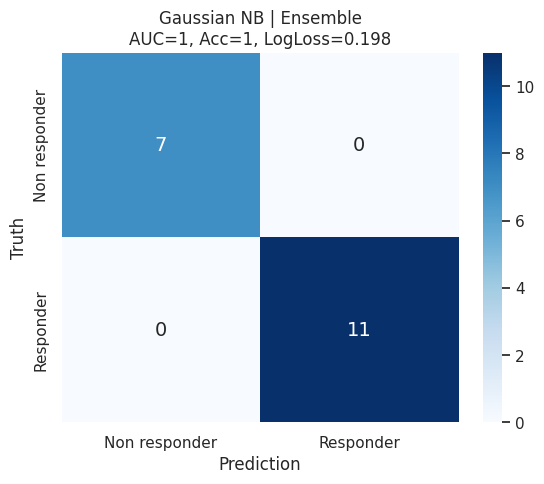

In [52]:
scores = utils.printScores(y, cv_gauss_ensemble["test_score"], confusion=True)
plt.title("Gaussian NB | Ensemble\nAUC=1, Acc=1, LogLoss=0.198")
plt.savefig("../imgs/confusionMatrices/gauss_ensemble.png",dpi=300, bbox_inches="tight")

In [ ]:
scores["threshold"]

0.540047248459723

In [55]:
printScoresPredicions(scores, y, y3)

,0,1,resp,respPart
ID,,,,
VNSLC_01,0.997035,True,1,2
VNSLC_02,0.540047,True,1,2
VNSLC_03,0.993357,True,1,2
VNSLC_04,0.997035,True,1,2
VNSLC_06,0.058092,False,0,0
VNSLC_07,0.641164,True,1,2
VNSLC_09,0.878267,True,1,2
VNSLC_10,0.999614,True,1,1
VNSLC_11,0.700257,True,1,2


## MLP

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from feature_engine.selection import SmartCorrelatedSelection
from ITMO_FS.filters import multivariate
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer

cv_mlp = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", RobustScaler().set_output(transform="pandas")),
            ("t-test", utils.MannwhitenFilter(0.05)),
            ("ANOVA", utils.KruskalFilter(y3, 0.05)),
            ("correlated", SmartCorrelatedSelection(threshold=0.95,missing_values="raise", selection_method="variance")),
            ("multivariate", multivariate.MultivariateFilter("MRMR", 20)),
            ("sfs", SFS(
                MLPClassifier(random_state=7, learning_rate="adaptive", max_iter=1000),
                k_features=(1,15),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", RandomizedSearchCV(
            MLPClassifier(random_state=7, learning_rate="adaptive", max_iter=1000),
            param_distributions={
                "alpha": stats.loguniform(1e-3, 1e1),
                "hidden_layer_sizes": [(100,), (50,), (20,)]
            },
            scoring="neg_log_loss", cv=3, n_jobs=1, random_state=7
        ))
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_proba=True),
    cv=LeaveOneOut(),
    n_jobs=8,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Op

[CV] END .................................................... total time= 7.4min
[CV] END .................................................... total time= 7.8min


/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .................................................... total time= 8.1min
[CV] END .................................................... total time= 8.2min
[CV] END .................................................... total time= 8.3min
[CV] END .................................................... total time= 8.4min
[CV] END .................................................... total time= 8.4min
[CV] END .................................................... total time= 8.5min


/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

[CV] END .................................................... total time= 8.2min


/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

[CV] END .................................................... total time= 8.0min
[CV] END .................................................... total time= 7.7min


/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

[CV] END .................................................... total time= 8.3min


/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .................................................... total time= 8.1min


[Parallel(n_jobs=8)]: Done  13 out of  18 | elapsed: 16.5min remaining:  6.4min
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .................................................... total time= 8.7min
[CV] END .................................................... total time= 8.4min
[CV] END .................................................... total time= 8.7min


/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cerra/Epilepsy-dMRI-VNS/env_dMRI/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

[CV] END .................................................... total time= 7.5min
[CV] END .................................................... total time= 7.6min


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed: 23.9min finished


In [16]:
most_selected = {}
for estimator in cv_mlp["estimator"]:
    for feature in estimator["selection"]["sfs"].k_feature_names_:
        if feature not in most_selected:
            most_selected[feature] = 0
        else:
            most_selected[feature] += 1
    
    # print(estimator["selection"]["sfs"].k_feature_names_)

most_selected

{'Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized': 12,
 'Left-Putamen_wfvf_lbp-3D-m1_firstorder_Median': 0,
 'lh.cbv_odi_wavelet-HHH_glszm_SizeZoneNonUniformity': 1,
 'Left-Accumbens-area_AD_lbp-3D-k_glcm_ClusterProminence': 0,
 'Right-Thalamus_wfvf_wavelet-HLL_glszm_SizeZoneNonUniformityNormalized': 0,
 'rh.uf_frac_csf_mf_wavelet-LLL_glszm_HighGrayLevelZoneEmphasis': 0}

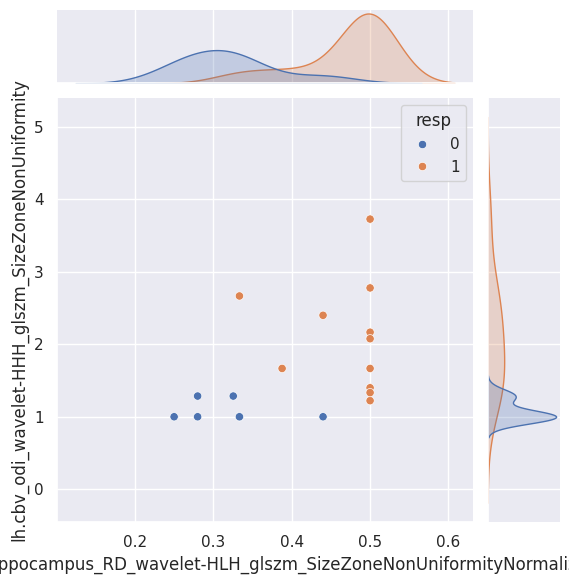

In [18]:
sns.jointplot(data=X, x='Right-Hippocampus_RD_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', y='lh.cbv_odi_wavelet-HHH_glszm_SizeZoneNonUniformity', hue=y, palette="deep")

AUC:		Test: 0.766
f1:		Test: 0.846
Accuracy:	Test: 0.429
Accuracy not adjusted: 0.714 0.778
Brier:		Test: 0.208
LogLoss:	Test 0.626


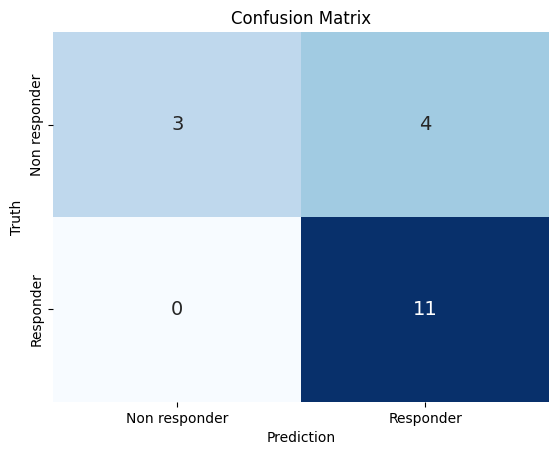

In [15]:
scores = utils.printScores(y, cv_mlp["test_score"], confusion=True)

In [ ]:
scores["threshold"]

0.17375073567309823

In [ ]:
printScoresPredicions(scores)

,0,1,resp,respPart
ID,,,,
VNSLC_01,0.902078,True,1,2
VNSLC_02,0.902078,True,1,2
VNSLC_03,0.751549,True,1,2
VNSLC_04,0.902078,True,1,2
VNSLC_06,0.351906,False,0,0
VNSLC_07,0.902078,True,1,2
VNSLC_09,0.902078,True,1,2
VNSLC_10,0.191709,False,1,1
VNSLC_11,0.502829,True,1,2


## Calibration

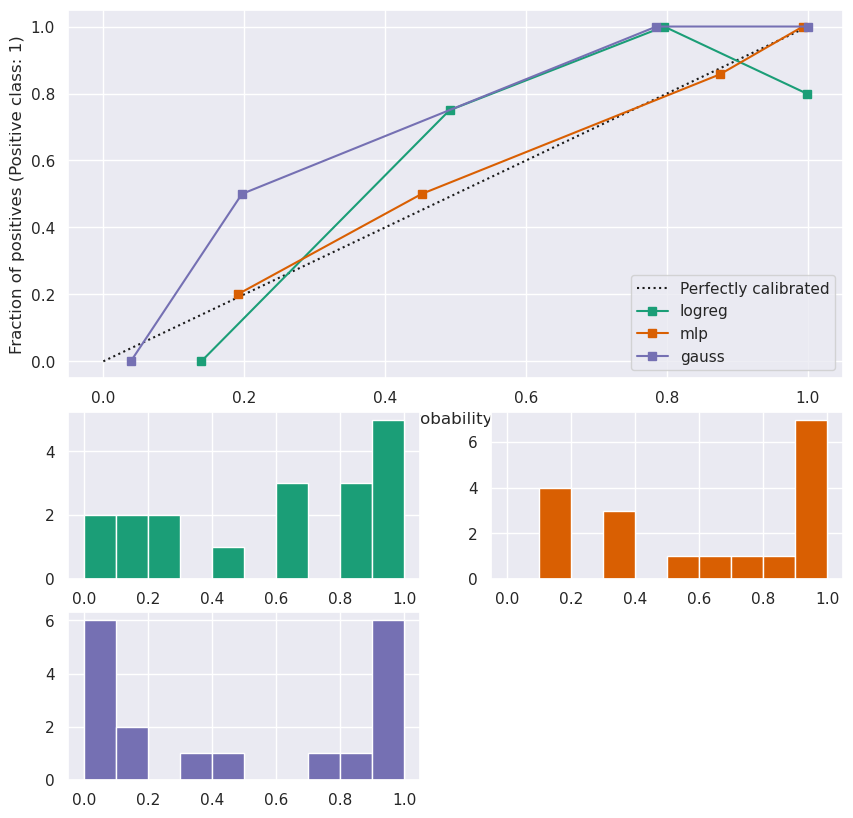

In [ ]:
from sklearn.calibration import CalibrationDisplay
from matplotlib.gridspec import GridSpec

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
bins = 4

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])

cal = []
cal.append(CalibrationDisplay.from_predictions(y, cv_log["test_score"],n_bins=bins,strategy="quantile", name="logreg", ax=ax_calibration_curve, color=colors(0)))
cal.append(CalibrationDisplay.from_predictions(y, cv_best_mlp["test_score"],n_bins=bins, strategy="quantile", name="mlp", ax=ax_calibration_curve, color=colors(1)))
cal.append(CalibrationDisplay.from_predictions(y, cv_gauss["test_score"],n_bins=bins, strategy="quantile", name="gauss", ax=ax_calibration_curve, color=colors(2)))

grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, name in enumerate(["logreg", "mlp", "gauss"]):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        cal[i].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )

# OLD

In [73]:
from radiomics0 import getFirstDS
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import cross_validate, LeaveOneOut
from sklearn.metrics import make_scorer, roc_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import utils

df = getFirstDS()

X, y, y3 = utils.splitFeatureLabels(df)

def getMostFrequentSelectedFeatures(estimator_list):
    most_selected = {}
    for estimator in estimator_list:
        for feature in estimator["selection"]["sfs"].k_feature_names_:
            if feature not in most_selected:
                most_selected[feature] = 1
            else:
                most_selected[feature] += 1
    return {k:v for k, v in sorted(most_selected.items(), key=lambda el:el[1], reverse=True) }

def printSelectedFeatures(estimator_list):
    for estimator in estimator_list:
        print(estimator["selection"]["sfs"].k_feature_names_)

def calc_f1(p_and_r):
    p, r = p_and_r
    if p == 0 and r == 0:
        return 0
    return (2*p*r)/(p+r)

def func(estimator_list):
    most_selected = {}
    for estimator in estimator_list:
        for feature in estimator["selection"]["sfs"].k_feature_names_:
            if feature not in most_selected:
                most_selected[feature] = 1
            else:
                most_selected[feature] += 1
    return {k:v for k, v in sorted(most_selected.items(), key=lambda el:el[1], reverse=True) }

In [13]:
from sklearn.preprocessing import StandardScaler

X = X.filter(regex=r'mean')

cv_logreg = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", StandardScaler().set_output(transform="pandas")),
            ("sfs", SFS(
                LogisticRegression(C=1e-6, dual=True, random_state=7, class_weight="balanced", n_jobs=1, solver="liblinear", max_iter=10000),
                k_features=(1,3),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", LogisticRegressionCV(random_state=7, class_weight="balanced", scoring="neg_log_loss", cv=3, n_jobs=1))
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_proba=True),
    cv=LeaveOneOut(),
    n_jobs=8,
    verbose=2,
    error_score="raise",
    return_estimator=True
)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=  14.8s
[CV] END .................................................... total time=  15.1s
[CV] END .................................................... total time=  15.1s
[CV] END .................................................... total time=  15.7s
[CV] END .................................................... total time=  15.8s
[CV] END .................................................... total time=  15.9s
[CV] END .................................................... total time=  16.6s
[CV] END .................................................... total time=  17.7s
[CV] END .................................................... total time=  13.2s
[CV] END .................................................... total time=  15.3s
[CV] END .................................................... total time=  14.2s
[CV] END .................................................... total time=  15.8s
[CV] END ...................

[Parallel(n_jobs=8)]: Done  13 out of  18 | elapsed:   31.1s remaining:   12.0s


[CV] END .................................................... total time=  16.5s
[CV] END .................................................... total time=  16.4s
[CV] END .................................................... total time=  18.3s
[CV] END .................................................... total time=  15.0s
[CV] END .................................................... total time=  14.6s


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:   44.8s finished


In [14]:
getMostFrequentSelectedFeatures(cv_logreg["estimator"])

{'right-accumbens-area_AD_mean': 5,
 'cc.bodyt_wFA_mean': 4,
 'lh.fx_AD_mean': 3,
 'left-fornix_MD_mean': 3,
 'acomm_fvf_tot_mean': 2,
 'right-fornix_RD_mean': 2,
 'mcp_frac_ctot_mean': 2,
 'right-fornix_wAD_mean': 1,
 'right-inf-longi-fasci_wFA_mean': 1,
 'left-accumbens-area_wMD_mean': 1,
 'left-fornix_icvf_mean': 1,
 'left-accumbens-area_fintra_mean': 1,
 'rh.ilf_frac_ftot_mean': 1,
 'left-postThalRadiation-occipital_icvf_mean': 1,
 'cc.bodyt_RD_mean': 1,
 'rh.cst_FA_mean': 1,
 'rh.emc_AD_mean': 1,
 'right-fornix_MD_mean': 1,
 'lh.mlf_fextra_mean': 1}

In [15]:
printSelectedFeatures(cv_logreg["estimator"])

('lh.fx_AD_mean', 'right-fornix_wAD_mean', 'right-inf-longi-fasci_wFA_mean')
('acomm_fvf_tot_mean', 'lh.fx_AD_mean')
('acomm_fvf_tot_mean', 'cc.bodyt_wFA_mean', 'lh.fx_AD_mean')
('left-accumbens-area_wMD_mean', 'right-fornix_RD_mean')
('cc.bodyt_wFA_mean', 'left-fornix_icvf_mean')
('left-fornix_MD_mean', 'mcp_frac_ctot_mean')
('left-accumbens-area_fintra_mean', 'left-fornix_MD_mean', 'rh.ilf_frac_ftot_mean')
('right-accumbens-area_AD_mean',)
('right-accumbens-area_AD_mean',)
('right-accumbens-area_AD_mean',)
('left-postThalRadiation-occipital_icvf_mean',)
('right-fornix_RD_mean',)
('right-accumbens-area_AD_mean',)
('cc.bodyt_RD_mean', 'left-fornix_MD_mean')
('cc.bodyt_wFA_mean', 'rh.cst_FA_mean', 'rh.emc_AD_mean')
('right-accumbens-area_AD_mean',)
('cc.bodyt_wFA_mean', 'right-fornix_MD_mean')
('lh.mlf_fextra_mean', 'mcp_frac_ctot_mean')


In [16]:
scores = utils.printScores(y, cv_logreg["test_score"], decision=True)

AUC:		Test: 0.610
f1:		Test: 0.815
Accuracy:	Test: 0.286
Accuracy not adjusted: 0.643 0.722


In [17]:
from sklearn.svm import LinearSVC

X, y, y3 = utils.splitFeatureLabels(df)
X = X.filter(regex=r'mean')

cv_linSVM = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", StandardScaler().set_output(transform="pandas")),
            ("sfs", SFS(
                LinearSVC(dual=True, C=1e-6, random_state=7, class_weight="balanced", max_iter=10000),
                k_features=(1,3),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", RandomizedSearchCV(
            LinearSVC(dual=True, random_state=7, class_weight="balanced"),
            param_distributions={
                "C": stats.loguniform(1e-6, 1)
            },
            scoring="roc_auc", cv=3, n_jobs=1, random_state=7
        ))
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_threshold=True),
    cv=LeaveOneOut(),
    n_jobs=8,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=  13.5s
[CV] END .................................................... total time=  13.6s
[CV] END .................................................... total time=  14.7s
[CV] END .................................................... total time=  15.0s
[CV] END .................................................... total time=  15.9s
[CV] END .................................................... total time=  16.3s
[CV] END .................................................... total time=  16.3s
[CV] END .................................................... total time=  16.9s
[CV] END .................................................... total time=  14.3s
[CV] END .................................................... total time=  15.0s
[CV] END .................................................... total time=  14.8s
[CV] END .................................................... total time=  14.9s
[CV] END ...................

[Parallel(n_jobs=8)]: Done  13 out of  18 | elapsed:   30.9s remaining:   11.9s


[CV] END .................................................... total time=  16.5s
[CV] END .................................................... total time=  15.9s
[CV] END .................................................... total time=  17.7s
[CV] END .................................................... total time=  13.3s
[CV] END .................................................... total time=  13.8s


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:   42.5s finished


In [18]:
getMostFrequentSelectedFeatures(cv_linSVM["estimator"])

{'right-accumbens-area_AD_mean': 5,
 'cc.bodyt_wFA_mean': 4,
 'lh.fx_AD_mean': 3,
 'left-fornix_MD_mean': 3,
 'acomm_fvf_tot_mean': 2,
 'right-fornix_RD_mean': 2,
 'mcp_frac_ctot_mean': 2,
 'right-fornix_wAD_mean': 1,
 'right-inf-longi-fasci_wFA_mean': 1,
 'left-accumbens-area_wMD_mean': 1,
 'left-fornix_icvf_mean': 1,
 'left-accumbens-area_fintra_mean': 1,
 'rh.ilf_frac_ftot_mean': 1,
 'left-postThalRadiation-occipital_icvf_mean': 1,
 'cc.bodyt_RD_mean': 1,
 'rh.cst_FA_mean': 1,
 'rh.emc_AD_mean': 1,
 'right-fornix_MD_mean': 1,
 'lh.mlf_fextra_mean': 1}

In [19]:
scores = utils.printScores(y, cv_linSVM["test_score"], decision=True)

AUC:		Test: 0.571
f1:		Test: 0.815
Accuracy:	Test: 0.286
Accuracy not adjusted: 0.643 0.722


In [20]:
from sklearn.svm import SVC

X, y, y3 = utils.splitFeatureLabels(df)
X = X.filter(regex=r'mean')

cv_rbfSVM = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", StandardScaler().set_output(transform="pandas")),
            ("sfs", SFS(
                SVC(C=1e-6, random_state=7, class_weight="balanced"),
                k_features=(1,3),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", RandomizedSearchCV(
            SVC(random_state=7, class_weight="balanced"),
            param_distributions={
                "C": stats.loguniform(1e-6, 1e-3),
                "gamma" : stats.loguniform(1e-6, 1)
            },
            scoring="roc_auc", cv=3, n_jobs=1, random_state=7
        ))
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_threshold=True),
    cv=LeaveOneOut(),
    n_jobs=8,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=  14.6s
[CV] END .................................................... total time=  15.2s
[CV] END .................................................... total time=  16.1s
[CV] END .................................................... total time=  16.4s
[CV] END .................................................... total time=  16.6s
[CV] END .................................................... total time=  16.8s
[CV] END .................................................... total time=  17.4s
[CV] END .................................................... total time=  18.9s
[CV] END .................................................... total time=  14.7s
[CV] END .................................................... total time=  15.6s
[CV] END .................................................... total time=  15.2s
[CV] END .................................................... total time=  14.7s
[CV] END ...................

[Parallel(n_jobs=8)]: Done  13 out of  18 | elapsed:   32.4s remaining:   12.5s


[CV] END .................................................... total time=  17.6s
[CV] END .................................................... total time=  18.9s
[CV] END .................................................... total time=  16.9s
[CV] END .................................................... total time=  14.7s
[CV] END .................................................... total time=  13.6s


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:   44.6s finished


In [21]:
getMostFrequentSelectedFeatures(cv_rbfSVM["estimator"])

{'cc.bodypm_fvf_tot_mean': 5,
 'left-postThalRadiation-occipital_fextra_mean': 4,
 'left-fornix_MD_mean': 3,
 'lh.mlf_fextra_mean': 2,
 'right-inf-longi-fasci_wAD_mean': 2,
 'left-infThalRadiation-temporal_wfvf_mean': 1,
 'lh.fx_fextra_mean': 1,
 'cc.bodypf_fvf_tot_mean': 1,
 'right-inf-longi-fasci_odi_mean': 1,
 'left-thalamus_odi_mean': 1,
 'lh.cst_wAD_mean': 1,
 'left-postThalRadiation-occipital_icvf_mean': 1,
 'lh.mlf_fvf_tot_mean': 1,
 'left-accumbens-area_wMD_mean': 1,
 'left-inf-longi-fasci_wfvf_mean': 1,
 'left-antThalRadiation_AD_mean': 1}

In [22]:
printSelectedFeatures(cv_rbfSVM["estimator"])

('cc.bodypm_fvf_tot_mean',)
('left-infThalRadiation-temporal_wfvf_mean',)
('cc.bodypm_fvf_tot_mean',)
('cc.bodypm_fvf_tot_mean', 'lh.fx_fextra_mean')
('left-postThalRadiation-occipital_fextra_mean',)
('cc.bodypf_fvf_tot_mean', 'lh.mlf_fextra_mean')
('left-postThalRadiation-occipital_fextra_mean',)
('left-fornix_MD_mean', 'right-inf-longi-fasci_odi_mean')
('left-thalamus_odi_mean', 'lh.cst_wAD_mean', 'right-inf-longi-fasci_wAD_mean')
('left-fornix_MD_mean', 'right-inf-longi-fasci_wAD_mean')
('left-postThalRadiation-occipital_icvf_mean',)
('lh.mlf_fvf_tot_mean',)
('left-accumbens-area_wMD_mean', 'left-fornix_MD_mean')
('cc.bodypm_fvf_tot_mean', 'left-inf-longi-fasci_wfvf_mean')
('cc.bodypm_fvf_tot_mean', 'lh.mlf_fextra_mean')
('left-antThalRadiation_AD_mean',)
('left-postThalRadiation-occipital_fextra_mean',)
('left-postThalRadiation-occipital_fextra_mean',)


In [23]:
utils.printScores(y, cv_rbfSVM["test_score"], decision=True)

AUC:		Test: 0.779
f1:		Test: 0.870
Accuracy:	Test: 0.623
Accuracy not adjusted: 0.812 0.833


{'auc': 0.7792207792207793,
 'f1': 0.8695652173913043,
 'accAdj': 0.6233766233766234,
 'acc': 0.8116883116883117,
 'threshold': -0.9999949665972833,
 'prob_decision': [-0.9999779688402557,
  -0.9999998751904673,
  -0.9999942071494848,
  -0.9999715997734334,
  -0.9999990644863287,
  -0.9999843831526579,
  1.000000756612594,
  -0.9999579315099009,
  -0.9999735541796858,
  -0.9999725074121318,
  -0.9999938831255619,
  -0.9999949665972833,
  0.9999952899477655,
  -0.9999473885686889,
  -0.9999967362557893,
  -0.9999963675177506,
  -0.9999977812139733,
  -0.9999985120822602]}

In [24]:
X, y, y3 = utils.splitFeatureLabels(df)
X = X.filter(regex=r'mean')

cv_polySVM = cross_validate(
    Pipeline([
        ("selection", Pipeline([
            ("outlier", utils.MADOutlierRemotion(3)),
            ("scaler", StandardScaler().set_output(transform="pandas")),
            ("sfs", SFS(
                SVC(C=1e-6, kernel="poly", random_state=7, class_weight="balanced"),
                k_features=(1,3),
                floating=True,
                scoring="roc_auc",
                cv=3,
            ))
        ])),
        ("clf", RandomizedSearchCV(
            SVC(kernel="poly", degree=3, random_state=7, class_weight="balanced"),
            param_distributions={
                "C": stats.loguniform(1e-6, 1e-3)
            },
            scoring="roc_auc", cv=3, n_jobs=1, random_state=7
        ))
    ]),
    X, y,
    scoring=make_scorer(utils.retScores, needs_threshold=True),
    cv=LeaveOneOut(),
    n_jobs=8,
    verbose=2,
    error_score="raise",
    return_estimator=True
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=  15.0s
[CV] END .................................................... total time=  15.8s
[CV] END .................................................... total time=  16.3s
[CV] END .................................................... total time=  16.5s
[CV] END .................................................... total time=  16.5s
[CV] END .................................................... total time=  16.9s
[CV] END .................................................... total time=  17.2s
[CV] END .................................................... total time=  18.4s
[CV] END .................................................... total time=  15.9s
[CV] END .................................................... total time=  14.6s
[CV] END .................................................... total time=  15.8s
[CV] END .................................................... total time=  16.6s
[CV] END ...................

[Parallel(n_jobs=8)]: Done  13 out of  18 | elapsed:   32.6s remaining:   12.5s


[CV] END .................................................... total time=  17.5s
[CV] END .................................................... total time=  16.7s
[CV] END .................................................... total time=  19.5s
[CV] END .................................................... total time=  14.8s
[CV] END .................................................... total time=  14.3s


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:   46.3s finished


In [25]:
getMostFrequentSelectedFeatures(cv_polySVM["estimator"])

{'rh.ilf_frac_ftot_mean': 5,
 'right-accumbens-area_AD_mean': 5,
 'rh.emc_AD_mean': 4,
 'lh.fx_AD_mean': 3,
 'mcp_frac_ctot_mean': 3,
 'left-fornix_MD_mean': 3,
 'right-fornix_RD_mean': 2,
 'cc.bodyt_wFA_mean': 2,
 'cc.bodyt_frac_ftot_mean': 1,
 'right-pallidum_wFA_mean': 1,
 'cc.bodyc_fvf_tot_mean': 1,
 'acomm_fvf_tot_mean': 1,
 'left-fornix_icvf_mean': 1,
 'right-inf-longi-fasci_wFA_mean': 1,
 'left-postThalRadiation-occipital_icvf_mean': 1,
 'left-antThalRadiation_AD_mean': 1,
 'right-pallidum_FA_mean': 1,
 'cc.bodyt_RD_mean': 1,
 'right-fornix_MD_mean': 1,
 'lh.mlf_fextra_mean': 1}

In [26]:
printSelectedFeatures(cv_polySVM["estimator"])

('cc.bodyt_frac_ftot_mean', 'lh.fx_AD_mean', 'right-pallidum_wFA_mean')
('cc.bodyc_fvf_tot_mean', 'lh.fx_AD_mean')
('acomm_fvf_tot_mean', 'lh.fx_AD_mean', 'rh.ilf_frac_ftot_mean')
('mcp_frac_ctot_mean', 'right-fornix_RD_mean')
('left-fornix_icvf_mean', 'right-inf-longi-fasci_wFA_mean')
('left-fornix_MD_mean', 'mcp_frac_ctot_mean')
('left-fornix_MD_mean', 'rh.ilf_frac_ftot_mean')
('rh.emc_AD_mean', 'rh.ilf_frac_ftot_mean', 'right-accumbens-area_AD_mean')
('rh.emc_AD_mean', 'rh.ilf_frac_ftot_mean', 'right-accumbens-area_AD_mean')
('rh.emc_AD_mean', 'rh.ilf_frac_ftot_mean', 'right-accumbens-area_AD_mean')
('left-postThalRadiation-occipital_icvf_mean',)
('right-fornix_RD_mean',)
('left-antThalRadiation_AD_mean', 'right-accumbens-area_AD_mean', 'right-pallidum_FA_mean')
('cc.bodyt_RD_mean', 'left-fornix_MD_mean')
('cc.bodyt_wFA_mean', 'rh.emc_AD_mean')
('right-accumbens-area_AD_mean',)
('cc.bodyt_wFA_mean', 'right-fornix_MD_mean')
('lh.mlf_fextra_mean', 'mcp_frac_ctot_mean')


In [27]:
utils.printScores(y, cv_polySVM["test_score"], decision=True)

AUC:		Test: 1.000
f1:		Test: 1.000
Accuracy:	Test: 1.000
Accuracy not adjusted: 1.000 1.000


{'auc': 1.0,
 'f1': 1.0,
 'accAdj': 1.0,
 'acc': 1.0,
 'threshold': 0.9997373275597587,
 'prob_decision': [0.9999759221584699,
  0.9999393750493591,
  0.9999352054711128,
  0.9999385968615891,
  -0.9998293565228957,
  0.9999340702003015,
  1.0001027287092048,
  0.999910066981697,
  0.9999148449468819,
  0.9999119861839567,
  -0.9996620969618715,
  0.9997373275597587,
  0.9998747635612222,
  -1.0001979479971195,
  -0.9999485151996563,
  -0.9997516871324745,
  -1.0000286776045462,
  -0.99988865000317]}

## final plots

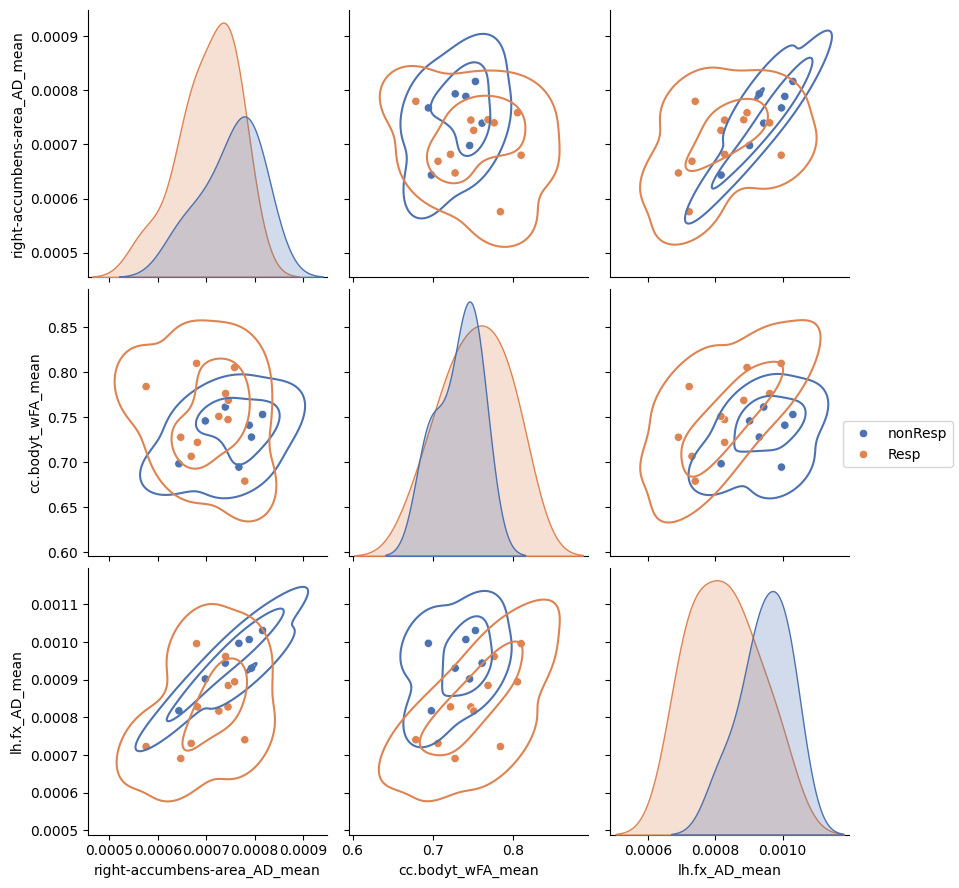

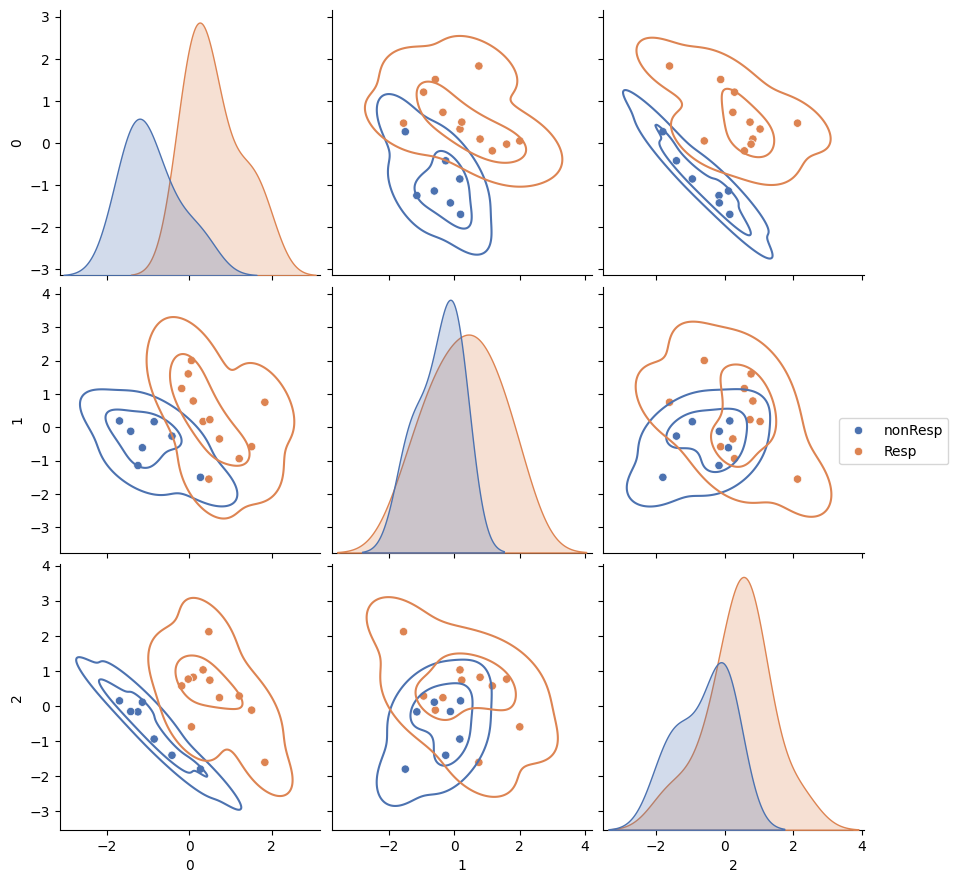

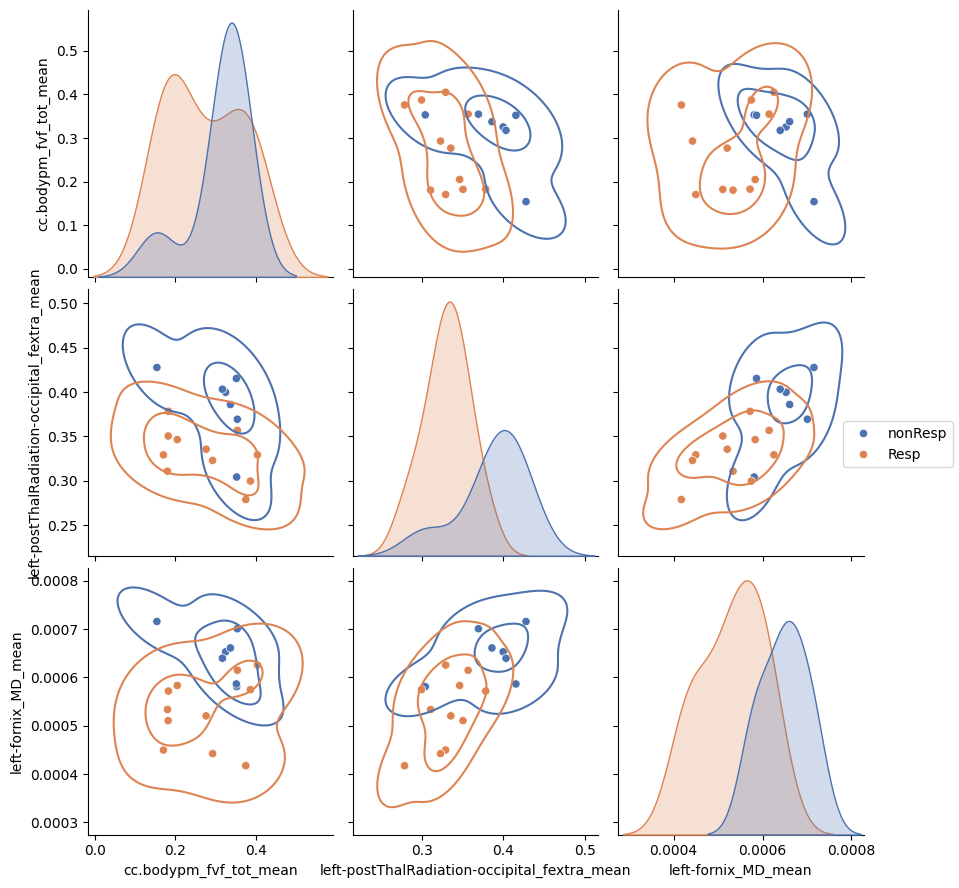

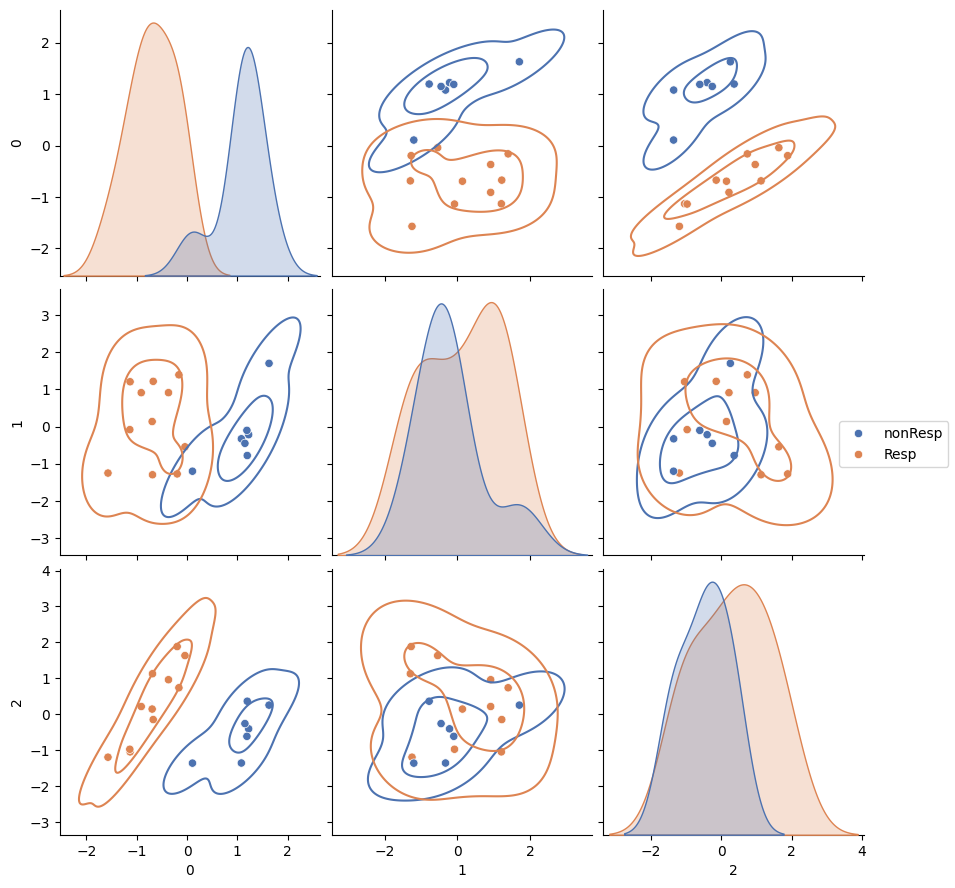

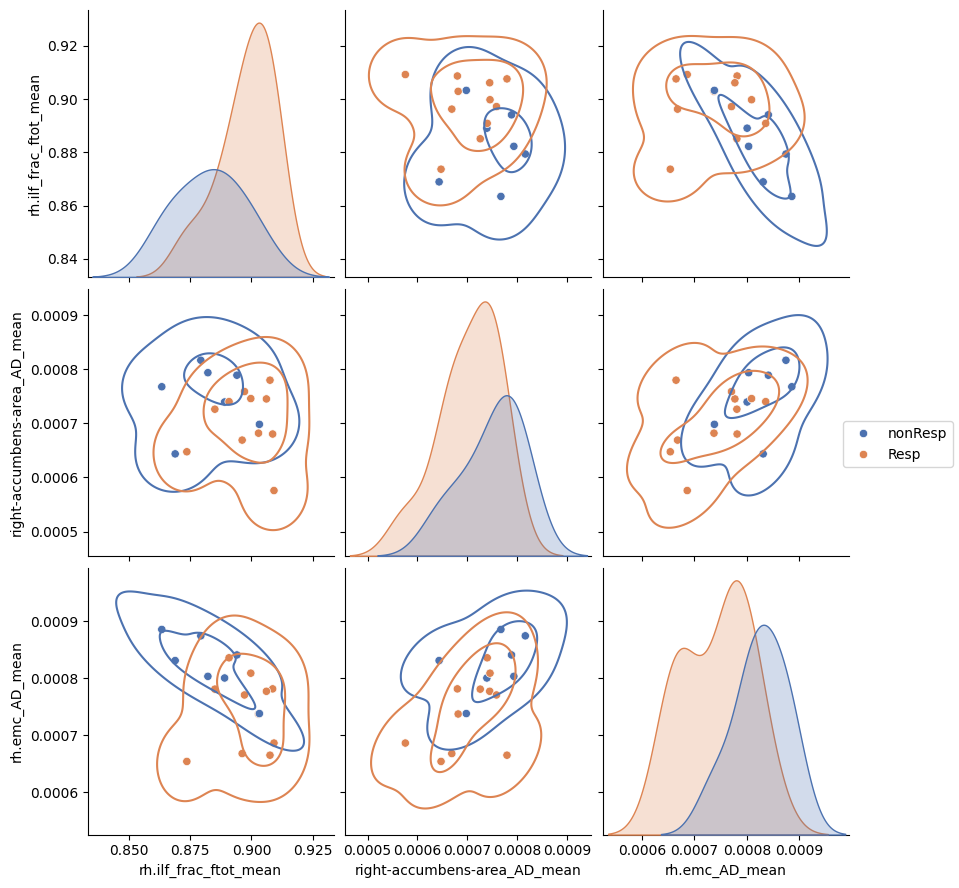

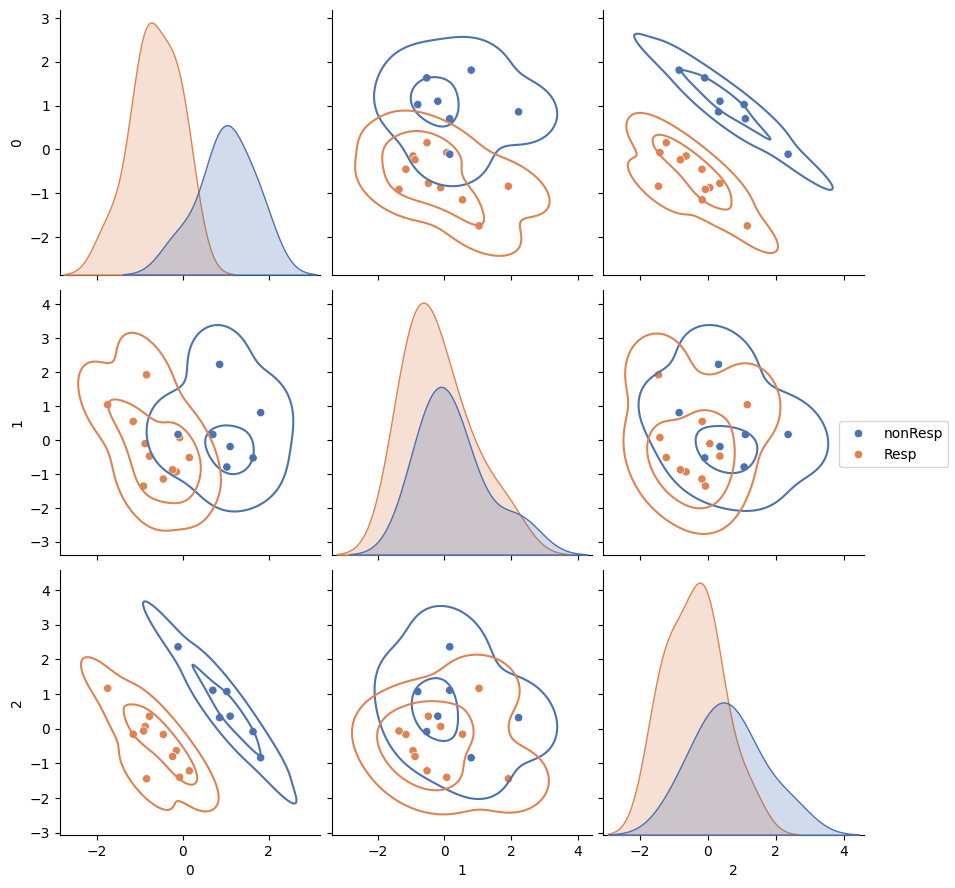

In [110]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

for name, toPlot in [
    ("logreg", ['right-accumbens-area_AD_mean', 'cc.bodyt_wFA_mean', "lh.fx_AD_mean"]),
    ("rbfsvm", ["cc.bodypm_fvf_tot_mean", "left-postThalRadiation-occipital_fextra_mean", "left-fornix_MD_mean"]),
    ("polySVM", ["rh.ilf_frac_ftot_mean", "right-accumbens-area_AD_mean", "rh.emc_AD_mean"])
]:
    X_plot = df[["resp",*toPlot]]
    for isPCA in [False, True]:

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("pca", PCA(
                n_components=3,
                whiten=True,
            ))
        ])
        X_plot_trans = X_plot
        if isPCA:
            X_plot_trans = pd.DataFrame(pipe.fit_transform(X_plot), index=X_plot.index)
            X_plot_trans = pd.concat([X_plot["resp"], X_plot_trans], axis=1)

        g = sns.pairplot(X_plot_trans, hue="resp", palette="deep", height=3)
        g.map_offdiag(sns.kdeplot, levels=3)
        g._legend.draw_frame(True)
        g._legend.set_alignment("left")
        g._legend.set_title("")
        g._legend.get_texts()[0].set_text("nonResp")
        g._legend.get_texts()[1].set_text("Resp")

        if isPCA:
            plt.savefig(f"../imgs/selectedFeatures/{name}-pca.png",dpi=300, bbox_inches="tight")
        else:
            plt.savefig(f"../imgs/selectedFeatures/{name}.png",dpi=300, bbox_inches="tight")

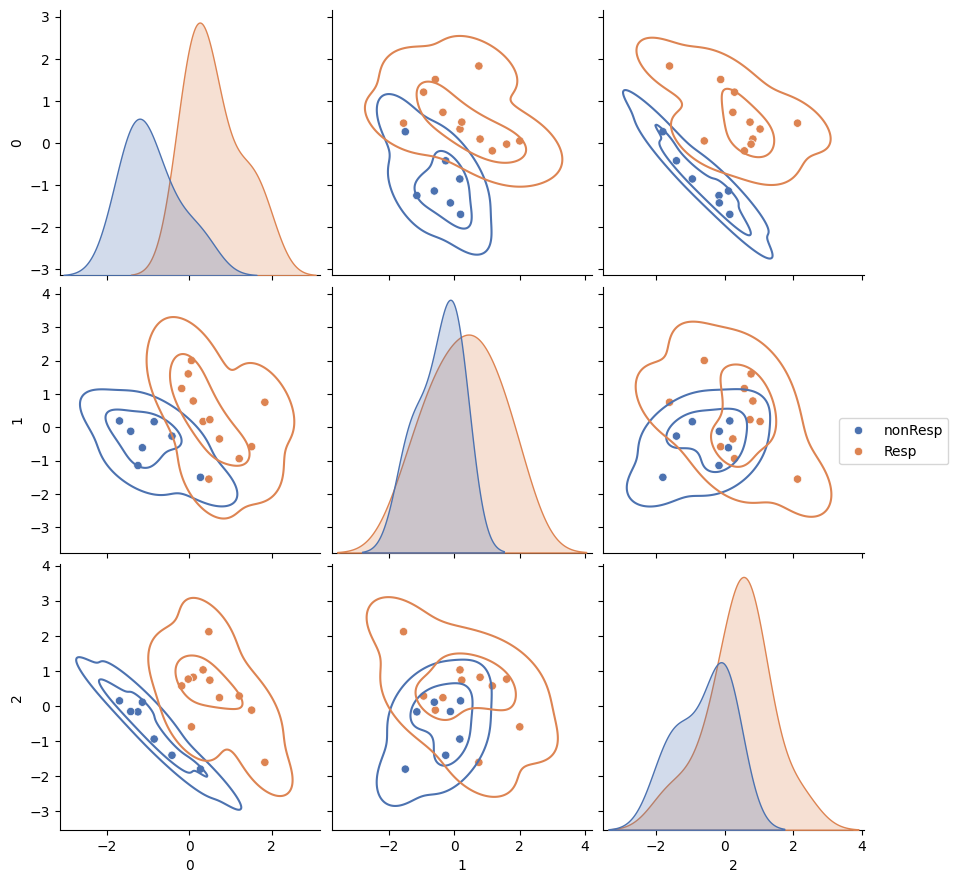

In [109]:


toPlot = ['right-accumbens-area_AD_mean', 'cc.bodyt_wFA_mean', "lh.fx_AD_mean"]
X_plot = df[["resp",*toPlot]]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(
        n_components=3,
        whiten=True,
    ))
])
X_plot_trans = X_plot
X_plot_trans = pd.DataFrame(pipe.fit_transform(X_plot), index=X_plot.index)
X_plot_trans = pd.concat([X_plot["resp"], X_plot_trans], axis=1)

g = sns.pairplot(X_plot_trans, hue="resp", palette="deep", height=3)
g.map_offdiag(sns.kdeplot, levels=3)
g._legend.draw_frame(True)
g._legend.set_alignment("left")
g._legend.set_title("")
g._legend.get_texts()[0].set_text("nonResp")
g._legend.get_texts()[1].set_text("Resp")

plt.savefig("../imgs/selectedFeatures/logreg-pca.png",dpi=300, bbox_inches="tight")

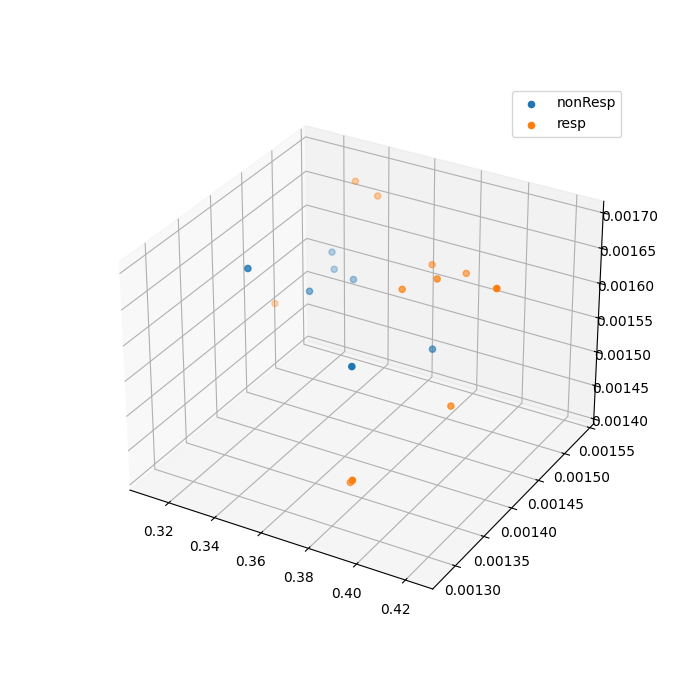

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# colors = ["red", "green"]

fig = plt.figure(figsize=(6,6))
fig.set_size_inches(7,7)
ax = fig.add_subplot(111, projection='3d')

# ax.set_title("Titolo di prova")
# ax.set_xlabel('rh.emc_AD_mean')
# ax.set_ylabel('rh.ilf_frac_ftot_mean')
# ax.set_zlabel('right-accumbens-area_AD_mean')
# ax.set_xlim(0, 50)
# ax.set_ylim(0, 15)
# ax.set_zlim(30, 80)
# ax.set_xticks([10, 30, 50])
# ax.grid(False)

for i, lab in enumerate(["nonResp", "resp"]):
    sub_df = df[df["resp"] == i]
    xs = sub_df['left-thalamus_odi_mean']
    ys = sub_df['lh.cst_wAD_mean']
    zs = sub_df['right-inf-longi-fasci_wAD_mean']

    scatter = ax.scatter(xs, ys, zs, marker="o", label=lab)
    # c := cambia colore
    # s := cambia dimensione del pallino (può anche dipendere da una variabile)


ax.legend(loc="best")

# cb = plt.colorbar(scatter, pad=0.2)
# cb.set_ticks([0, 1])
# cb.set_ticklabels(["nonResp", "Resp"])

plt.show()